## Numpy

In [1]:
import numpy as np

openArray = np.array([1,2,3,3], dtype='float64')
highArray = np.array([2,3,4,3], dtype='float64')
lowArray = np.array([0.5, 1.5, 2.5,1.5], dtype='float64')
closeArray = np.array([1.5, 2.5,3.5, 2.5], dtype='float64')

## Pandas

In [2]:
import pandas as pd

timeIndex = pd.date_range("20180808",periods=len(closeArray))
print(timeIndex)

DatetimeIndex(['2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11'], dtype='datetime64[ns]', freq='D')


In [3]:
candleDF = pd.concat([pd.Series(openArray), pd.Series(highArray), pd.Series(lowArray), pd.Series(closeArray)], axis=1, keys =('open', 'high', 'low', 'close') )
candleDF.index = timeIndex

## talib

In [4]:
import talib as ta

EMA = pd.Series(ta.EMA(closeArray,2), index=timeIndex)

## matplotlib & mpl_finance

In [5]:
from matplotlib.pylab import date2num

candleDF['time'] = list(map(date2num, candleDF.index))
candle = candleDF.reindex_axis(["time", "open", "high", "low", "close"], 1).values

/Users/zinchuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  after removing the cwd from sys.path.


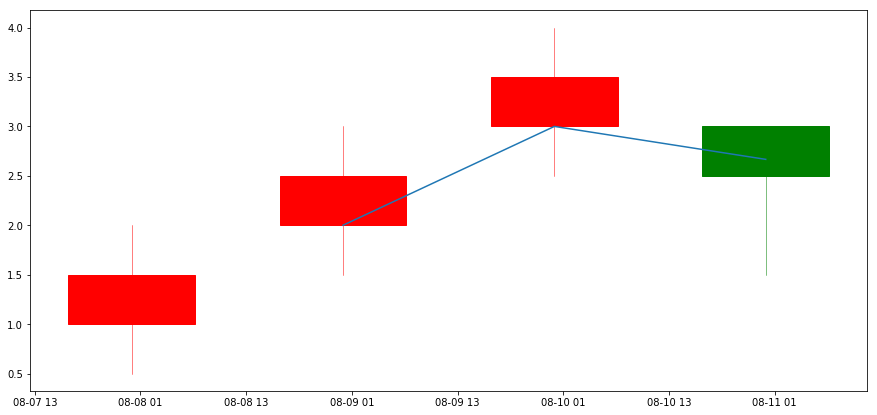

In [6]:
import matplotlib.pyplot as plt
import mpl_finance

fig, (ax) = plt.subplots(1,1,sharex=True, figsize=(15,7))
mpl_finance.candlestick_ohlc(ax, candle, width=0.6, colorup='r', colordown='g',alpha=1.0)
ax.plot(EMA)
ax.xaxis_date()
plt.show()

## requests & bs4

In [7]:
import requests
r=requests.get("http://bbs.fxdayu.com")

In [8]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")
bsObj=BeautifulSoup(r.text)
topics=bsObj.findAll("div",{"class":"row"})

In [9]:
name_list=[]
for t in topics:
    name=t.find("a",{"class":"username"})
    if  name:
        name=name.text
    else :
        continue
    name_list.append(name)
print(set(name_list))

set()


## Pandas CSV

In [10]:
filename = "../Day4/1_MongodbInputData/HFData1M.csv"
csv_df = pd.read_csv(filename).iloc[-2000:]
csv_df["datetime"] = csv_df["datetime"].apply(pd.to_datetime)
csv_df.tail()

FileNotFoundError: File b'../Day4/1_MongodbInputData/HFData1M.csv' does not exist

## MongoDB

In [ ]:
from pymongo import MongoClient
import os

url = os.environ.get("MONGODB_URL", "localhost:27017")

client = MongoClient(url)
collection = client["test"]["IF88:CTP"]

In [ ]:
# insert
result = collection.insert_many(csv_df.to_dict("record"))
print("Inserted count:", len(result.inserted_ids))

In [ ]:
# read
mdata = pd.DataFrame(list(collection.find(projection={"_id": 0})))
print(mdata.shape)
mdata.tail()

## hdf

In [ ]:
hdf_file = "./test.hdf"

# write
csv_df.to_hdf(hdf_file, "/table", mode="w")

In [ ]:
# read
import os

hdata = pd.read_hdf(hdf_file, "/table")
print(hdata.shape)
hdata.tail()

## jaqs & factor data

In [ ]:
from jaqs_fxdayu.data import DataView # 可以视为一个轻量级的数据库，数据格式基于pandas，方便数据的调用和处理
from jaqs_fxdayu.data import RemoteDataService # 数据服务，用于下载数据
import os
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
dataview_folder = '../Factor'

if not (os.path.isdir(dataview_folder)):
    os.makedirs(dataview_folder)

# 加载数据

dv = DataView()
dv.load_dataview(dataview_folder)

pb_raw = dv.get_ts("pb")
print(pb_raw.head())
pb = pb_raw.rename_axis(lambda x: datetime.strptime(str(x),"%Y%m%d")).stack()

print(pb.head())

## alphalens

In [ ]:
import alphalens

prices = dv.get_ts("close_adj").rename_axis(lambda x: datetime.strptime(str(x),"%Y%m%d"))

#计算目标股票池每只股票的持有期收益，和对应因子值的quantile分类
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(pb, prices, quantiles=5, periods=(1,5,10))
factor_data.head()

## plot

In [ ]:
import matplotlib.pyplot as plt
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True, demeaned=True)

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

## bokeh

In [ ]:
from vnpy.trader.utils.htmlplot.xcore import XMultiPlot

pdata = csv_df.iloc[-2000:]

carray = pdata["close"].values

ema = pd.DataFrame(
    {
        "ema5": ta.EMA(carray, 5),
        "ema25": ta.EMA(carray, 25)
    },
    index=pdata["datetime"]
).reset_index()


xmp = XMultiPlot("10m", "test.html")
xmp.addCandle(pdata, pos=0)
xmp.addLine(ema, pos=0)
xmp.addVBar(pdata[["datetime", "volume"]])
xmp.show()